# Detector de Ciberacoso en Twitter
Este proyecto desarrolla un sistema de Detección de Ciberacoso Multi-clase basado en técnicas de Procesamiento del Lenguaje Natural (NLP) y Deep Learning. 
-	Preprocesamiento exhaustivo que incluye la limpieza de ruido (emojis, URLs), normalización y traducción de tweets al inglés
-	Se emplea un modelo BERT (Bidirectional Encoder Representations from Transformers) pre-entrenado (bert-base-uncased), el cual es sometido a un proceso de Fine-Tuning para clasificar los mensajes en seis categorías de toxicidad (incluyendo racismo, sexismo y acoso religioso). La metodología asegura la integridad estadística mediante un muestreo estratificado
-	Evaluación del rendimiento del modelo utilizando métricas robustas como el F1-Score ponderado y matrices de confusión, permitiendo no solo detectar el acoso, sino identificar su tipología específica con alta precisión.


## 0. Instalación e importación librerias

In [1]:
# --- 1. CONFIGURACIÓN E IMPORTACIONES ---
import sys

# Instalación de librerías necesarias (solo si no están instaladas)
# Se usa sys.executable para asegurar que se instalan en el kernel actual
!{sys.executable} -m pip install deep-translator emoji contractions transformers torch accelerate -U -q

import pandas as pd
import re
import emoji
import contractions
import os
from deep_translator import GoogleTranslator
from sklearn.model_selection import train_test_split

print("✅ Librerías instaladas e importadas correctamente.")

✅ Librerías instaladas e importadas correctamente.


## 1. Preprocesamiento de los datos (limpieza y traducción)

In [2]:
# --- 2. FUNCIÓN UNIFICADA DE LIMPIEZA Y TRADUCCIÓN ---

def clean_and_translate(text):
    """
    Realiza la limpieza completa y traducción de un tweet.
    Combina limpieza robusta, expansión de contracciones y traducción.
    """
    # 1. Validación básica
    if not isinstance(text, str) or not text.strip():
        return ""
    
    # 2. Expandir contracciones (ej: don't -> do not) - Ayuda al modelo
    text = contractions.fix(text)
    
    # 3. Convertir a minúsculas
    text = text.lower()
    
    # 4. Eliminar URLs y HTML
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    
    # 5. Eliminar Emojis
    text = emoji.replace_emoji(text, replace='')
    
    # 6. Eliminar Menciones (@usuario)
    text = re.sub(r'@\w+', '', text)
    
    # 7. Eliminar Hashtags (solo el símbolo #)
    text = re.sub(r'#', '', text) 

    # 8. Eliminar caracteres especiales y números (mantener solo letras y espacios)
    # Nota: Se eliminan números para reducir ruido, según lógica de "deep_clean"
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 9. Eliminar letras repetidas exageradas (ej: "holaaaaa" -> "hola")
    pattern = re.compile(r"(.)\1{2,}")
    text = pattern.sub(r"\1\1", text)
    
    # 10. Normalizar espacios
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 11. Validación post-limpieza (si quedó vacío o muy corto)
    if len(text.split()) < 3: # Menos de 3 palabras suele ser ruido
        return ""

    # 12. Traducción (Google Translator)
    try:
        # Traduce automáticamente al inglés
        return GoogleTranslator(source='auto', target='en').translate(text)
    except:
        return text # Si falla, devuelve el texto limpio original

print("✅ Función 'clean_and_translate' definida.")

✅ Función 'clean_and_translate' definida.


In [4]:
# --- 3. PROCESAMIENTO DEL DATASET COMPLETO ---

INPUT_FILE = 'cyberbullying_tweets_original.csv'
OUTPUT_FILE = 'cyberbullying_tweets_processed.csv'
BATCH_SIZE = 1000

# Cargar dataset original
if os.path.exists(INPUT_FILE):
    df = pd.read_csv(INPUT_FILE)
    total_tweets = len(df)
    print(f"📂 Dataset cargado: {total_tweets} tweets.")
else:
    print(f"❌ No se encuentra el archivo {INPUT_FILE}")
    total_tweets = 0

# Verificar si ya existe un archivo de progreso para continuar
if os.path.exists(OUTPUT_FILE):
    df_processed = pd.read_csv(OUTPUT_FILE)
    start_index = len(df_processed)
    print(f"🔄 Resumiendo proceso desde el tweet {start_index}...")
else:
    start_index = 0
    # Crear archivo vacío con cabeceras si no existe
    pd.DataFrame(columns=['tweet_text_original', 'cyberbullying_type', 'tweet_text_clean']).to_csv(OUTPUT_FILE, index=False)
    print("🆕 Iniciando nuevo procesamiento...")

# Bucle de procesamiento por lotes
for i in range(start_index, total_tweets, BATCH_SIZE):
    end_i = min(i + BATCH_SIZE, total_tweets)
    print(f"   ⚙️ Procesando lote: {i} a {end_i}...")
    
    # Seleccionar lote
    batch = df.iloc[i:end_i].copy()
    
    # Aplicar limpieza y traducción
    # Usamos una lista para guardar resultados y crear DataFrame después (más eficiente)
    processed_data = []
    
    for idx, row in batch.iterrows():
        original = row['tweet_text']
        label = row['cyberbullying_type']
        
        cleaned = clean_and_translate(original)
        
        # Solo guardamos si el resultado no es vacío
        if cleaned:
            processed_data.append({
                'tweet_text_original': original,
                'cyberbullying_type': label,
                'tweet_text_clean': cleaned
            })
            
    # Guardar lote procesado en el CSV (modo 'append')
    if processed_data:
        df_batch = pd.DataFrame(processed_data)
        df_batch.to_csv(OUTPUT_FILE, mode='a', header=False, index=False)
        
    print(f"   ✅ Lote guardado. Progreso: {end_i}/{total_tweets}")

print("\n🎉 ¡Procesamiento completado!")

📂 Dataset cargado: 47692 tweets.
🆕 Iniciando nuevo procesamiento...
   ⚙️ Procesando lote: 0 a 1000...
   ✅ Lote guardado. Progreso: 1000/47692
   ⚙️ Procesando lote: 1000 a 2000...
   ✅ Lote guardado. Progreso: 2000/47692
   ⚙️ Procesando lote: 2000 a 3000...
   ✅ Lote guardado. Progreso: 3000/47692
   ⚙️ Procesando lote: 3000 a 4000...
   ✅ Lote guardado. Progreso: 4000/47692
   ⚙️ Procesando lote: 4000 a 5000...
   ✅ Lote guardado. Progreso: 5000/47692
   ⚙️ Procesando lote: 5000 a 6000...
   ✅ Lote guardado. Progreso: 6000/47692
   ⚙️ Procesando lote: 6000 a 7000...
   ✅ Lote guardado. Progreso: 7000/47692
   ⚙️ Procesando lote: 7000 a 8000...
   ✅ Lote guardado. Progreso: 8000/47692
   ⚙️ Procesando lote: 8000 a 9000...
   ✅ Lote guardado. Progreso: 9000/47692
   ⚙️ Procesando lote: 9000 a 10000...
   ✅ Lote guardado. Progreso: 10000/47692
   ⚙️ Procesando lote: 10000 a 11000...
   ✅ Lote guardado. Progreso: 11000/47692
   ⚙️ Procesando lote: 11000 a 12000...
   ✅ Lote guardado. P

revisar datos
- parece que no elimina todas las contacciones, buscar por '

## 2. División datos (estratificada)

In [5]:
# --- 4. PREPARACIÓN PARA ENTRENAMIENTO (CARGA Y SPLIT) ---

# Cargar el dataset procesado completo
if os.path.exists(OUTPUT_FILE):
    df_final = pd.read_csv(OUTPUT_FILE)
    print(f"📊 Datos finales cargados: {len(df_final)} registros.")
else:
    print("⚠️ No se encontró el archivo procesado. Ejecuta el paso anterior.")
    df_final = pd.DataFrame()

if not df_final.empty:
    # 1. Mapeo de etiquetas
    label_map = {
        'not_cyberbullying': 0,
        'gender': 1,
        'religion': 2,
        'age': 3,
        'ethnicity': 4,
        'other_cyberbullying': 5 
    }
    
    df_final['label'] = df_final['cyberbullying_type'].map(label_map)
    
    # Eliminar filas con etiquetas desconocidas (si las hay)
    df_final = df_final.dropna(subset=['label'])
    df_final['label'] = df_final['label'].astype(int)

    # 2. División Train/Test (Stratified)
    X = df_final['tweet_text_clean'].astype(str) # Asegurar string
    y = df_final['label']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"✅ Datos divididos: Train ({len(X_train)}), Test ({len(X_test)})")
    print("   Distribución de clases mantenida.")
    
    # Mostrar muestra
    display(df_final.head())

📊 Datos finales cargados: 46375 registros.
✅ Datos divididos: Train (37100), Test (9275)
   Distribución de clases mantenida.


,tweet_text_original,cyberbullying_type,tweet_text_clean,label
0,"In other words #katandandre, your food was cra...",not_cyberbullying,in other words katandandre your food was crapi...,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,why is aussietv so white mkr theblock imaceleb...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,a classy whore or more red velvet cupcakes,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thanks for the heads up but not too conc...,0
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,this is an isis account pretending to be a kur...,0


## 3. Tokenización
*Max_length=128

In [6]:
# --- 5. TOKENIZACIÓN Y DATASET ---
from transformers import BertTokenizerFast
from torch.utils.data import Dataset
import torch

# 1. Cargar Tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(model_name)

# 2. Definir Clase Dataset
class CyberBullyingDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 3. Crear Datasets
if 'X_train' in locals() and 'y_train' in locals():
    print("📦 Tokenizando datos...")
    train_dataset = CyberBullyingDataset(X_train.tolist(), y_train.tolist(), tokenizer)
    test_dataset = CyberBullyingDataset(X_test.tolist(), y_test.tolist(), tokenizer)
    print(f"✅ Datasets listos. Train: {len(train_dataset)}, Test: {len(test_dataset)}")
else:
    print("⚠️ X_train/y_train no definidos. Ejecuta el paso 4.")

📦 Tokenizando datos...
✅ Datasets listos. Train: 37100, Test: 9275


## 4. Entrenamiento (Fine-Tuning)

In [9]:
# intalar transformer y keras
%pip install transformers keras -U -q

Note: you may need to restart the kernel to use updated packages.


In [11]:
%pip install tf-keras

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 23.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [13]:
# --- 6. ENTRENAMIENTO DEL MODELO (BERT) ---
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# 1. Configuración
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🖥️ Entrenando en: {device.upper()}")

# Aseguramos que el nombre del modelo esté definido (por si no se ejecutó la celda anterior)
model_name = 'bert-base-uncased'
NUM_LABELS = 6

# Cargar modelo
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS)
model.to(device)

# 2. Métricas
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Manejo robusto de predicciones (por si devuelve tupla)
    if isinstance(predictions, tuple):
        predictions = predictions[0]
    
    preds = np.argmax(predictions, axis=1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

# 3. Argumentos
training_args = TrainingArguments(
    output_dir='./resultados_bullying',
    num_train_epochs=2,              
    per_device_train_batch_size=8,   
    per_device_eval_batch_size=16,   
    gradient_accumulation_steps=2,   
    warmup_steps=100,                
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10, 
    eval_strategy="epoch",           # Nombre correcto en versiones recientes de transformers
    save_strategy="epoch",           
    load_best_model_at_end=True,     
    report_to="none"                 
)

# 4. Trainer
if 'train_dataset' in locals() and 'test_dataset' in locals():
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics 
    )

    # 5. Ejecutar
    print("🚀 Iniciando entrenamiento...")
    trainer.train()

    # 6. Guardar
    trainer.save_model("./modelo_final_bullying")
    # Guardar tokenizer también si está disponible
    if 'tokenizer' in locals():
        tokenizer.save_pretrained("./modelo_final_bullying")
    print("✅ Modelo guardado en './modelo_final_bullying'")

    # 7. Generar Predicciones para Evaluación
    print("🔮 Generando predicciones para evaluación...")
    preds_output = trainer.predict(test_dataset)
    
    if isinstance(preds_output.predictions, tuple):
        y_pred = np.argmax(preds_output.predictions[0], axis=1)
    else:
        y_pred = np.argmax(preds_output.predictions, axis=1)
        
    y_true = preds_output.label_ids

else:
    print("⚠️ Error: 'train_dataset' o 'test_dataset' no están definidos. Ejecuta el paso 5 (Tokenización) primero.")

🖥️ Entrenando en: CPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Iniciando entrenamiento...


c:\Users\ddiaz\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.368000,0.353100,0.857143,0.855786
2,0.373100,0.359554,0.864151,0.863056


c:\Users\ddiaz\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✅ Modelo guardado en './modelo_final_bullying'
🔮 Generando predicciones para evaluación...


c:\Users\ddiaz\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


## 5. Evaluación del Modelo

### · Reporte de clasificación

In [14]:
# Definimos los nombres de las etiquetas en orden (0 a 5)
# Asegúrate de que coinciden con tu label_map original
target_names = [
    'Not Cyberbullying', # 0
    'Gender',            # 1
    'Religion',          # 2
    'Age',               # 3
    'Ethnicity',         # 4
    'Other'              # 5
]

print("\n--- 📊 REPORTE DE CLASIFICACIÓN DETALLADO ---")
report = classification_report(y_true, y_pred, target_names=target_names)
print(report)


--- 📊 REPORTE DE CLASIFICACIÓN DETALLADO ---
                   precision    recall  f1-score   support

Not Cyberbullying       0.71      0.51      0.59      1495
           Gender       0.91      0.88      0.89      1568
         Religion       0.95      0.96      0.96      1599
              Age       0.99      0.98      0.98      1598
        Ethnicity       0.99      0.98      0.98      1591
            Other       0.60      0.82      0.70      1424

         accuracy                           0.86      9275
        macro avg       0.86      0.85      0.85      9275
     weighted avg       0.86      0.86      0.86      9275



### · Matriz de confusión (heatmap)

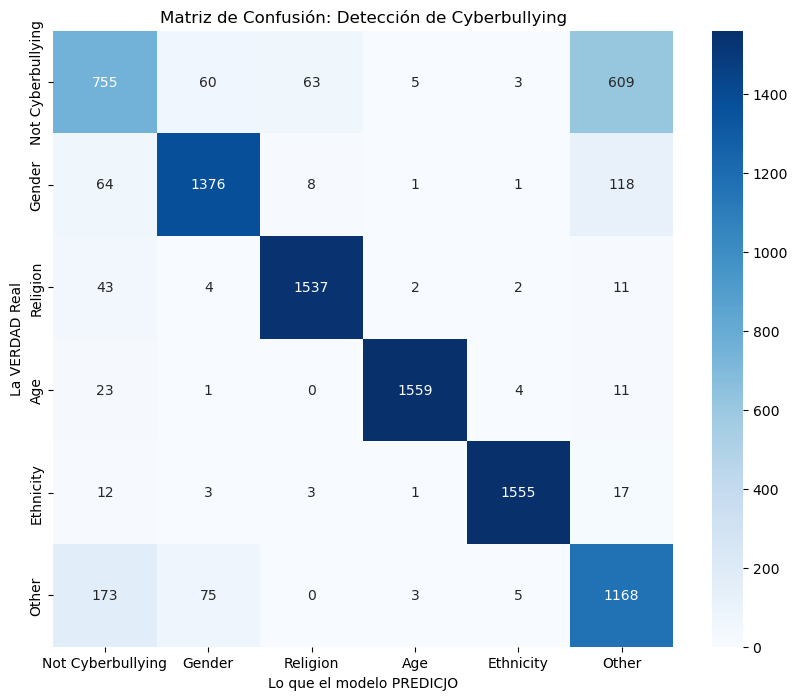

In [15]:
# Crear la matriz
cm = confusion_matrix(y_true, y_pred)

# Visualización bonita con Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names)

plt.xlabel('Lo que el modelo PREDICJO')
plt.ylabel('La VERDAD Real')
plt.title('Matriz de Confusión: Detección de Cyberbullying')
plt.show()

### · Auditoría de errores

In [16]:
import pandas as pd

# Necesitamos recuperar el texto original de X_test (que convertimos a lista antes)
# X_test es una lista de textos, y_true y y_pred son arrays de números

# 1. Crear un DataFrame con los resultados
df_resultados = pd.DataFrame({
    'Texto_Tweet': list(X_test),       # Texto original
    'Real_Label': y_true,              # Etiqueta numérica real
    'Pred_Label': y_pred               # Predicción del modelo
})

# 2. Mapear los números a nombres para leerlo mejor
inv_map = {i: name for i, name in enumerate(target_names)}
df_resultados['Real_Nombre'] = df_resultados['Real_Label'].map(inv_map)
df_resultados['Pred_Nombre'] = df_resultados['Pred_Label'].map(inv_map)

# 3. Filtrar SOLO los errores
df_errores = df_resultados[df_resultados['Real_Label'] != df_resultados['Pred_Label']]

print(f"Total de errores encontrados: {len(df_errores)} de {len(df_resultados)} pruebas.")
print("\n--- 🕵️‍♀️ EJEMPLOS DE ERRORES DEL MODELO ---")

# Mostramos 10 ejemplos aleatorios de errores
if len(df_errores) > 0:
    display(df_errores.sample(min(10, len(df_errores))))
else:
    print("¡Increíble! No hubo errores en este set de prueba.")

Total de errores encontrados: 1325 de 9275 pruebas.

--- 🕵️‍♀️ EJEMPLOS DE ERRORES DEL MODELO ---


,Texto_Tweet,Real_Label,Pred_Label,Real_Nombre,Pred_Nombre
6127,this are not school,3,0,Age,Not Cyberbullying
3126,you already know i am good alive and well how ...,0,5,Not Cyberbullying,Other
6101,the real work is just getting started,0,5,Not Cyberbullying,Other
1097,oops sorry for the belated content warning on ...,0,5,Not Cyberbullying,Other
8060,ruby seems like it would have a lot of stuff t...,0,5,Not Cyberbullying,Other
3211,working on it,0,5,Not Cyberbullying,Other
1793,calling someone sexist worse than sexism i am ...,0,1,Not Cyberbullying,Gender
8633,you were bullying me yesterday kn your palm tr...,0,5,Not Cyberbullying,Other
2684,rt at the very least questions will be raised ...,0,5,Not Cyberbullying,Other
1898,rt mkr i want to slap that smirk off kats face...,5,1,Other,Gender


### · Pensar que se puede hacer con Not_cyberbullying vs Other

In [19]:
# ver aleatoriamente 30 tweets clasificados como other_cyberbullying y que son not_cyberbullying
df_other_errors = df_resultados[
    (df_resultados['Real_Nombre'] == 'Not Cyberbullying') & 
    (df_resultados['Pred_Nombre'] == 'Other')
]
df_other_sample = df_other_errors.sample(min(30, len(df_other_errors)))
print(f"Mostrando {len(df_other_sample)} ejemplos de tweets clasificados erróneamente como 'Other' cuando son 'Not Cyberbullying':")
display(df_other_sample)

Mostrando 30 ejemplos de tweets clasificados erróneamente como 'Other' cuando son 'Not Cyberbullying':


,Texto_Tweet,Real_Label,Pred_Label,Real_Nombre,Pred_Nombre
8841,man you bulling,0,5,Not Cyberbullying,Other
7079,i will shoot you a dm when i have got a solid eta,0,5,Not Cyberbullying,Other
1917,really really really want to go to blizzcon bu...,0,5,Not Cyberbullying,Other
2876,as a target of her delusions yeah i am going t...,0,5,Not Cyberbullying,Other
6184,you could repeat that but your job is getting ...,0,5,Not Cyberbullying,Other
4935,blame for writing it p,0,5,Not Cyberbullying,Other
1530,but if someone wants to create companies that ...,0,5,Not Cyberbullying,Other
2257,eyi buti i am struggling with dis twitter ting...,0,5,Not Cyberbullying,Other
1956,i want her outfit it is so cute eyes sparkle,0,5,Not Cyberbullying,Other
3150,yupp jason does not have a lot of experience o...,0,5,Not Cyberbullying,Other
